# Universal Cell Embeddings
If you want to learn more about the method please read the [paper](https://www.biorxiv.org/content/10.1101/2023.11.28.568918v1) and the [SATURN method](https://www.nature.com/articles/s41592-024-02191-z).

In [1]:
from accelerate import Accelerator
import anndata as ad
import numpy as np
import json

/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Before using the UCE Model please define your model configurations in the json file

In [2]:
with open('./uce_config.json') as f:
    config = json.load(f)

## Loading the Test Data

In [3]:
ann_data = ad.read_h5ad("./data/10k_pbmcs_proc.h5ad")

## Load the UCE Model via the Helical Python Package

Once the package is installed, you can easily load the UCE model and the Helical Package will easily transform your data into the right format and you can then use it with the model.

In [5]:
from helical.models.uce.model import UCE
accelerator = Accelerator(project_dir=config["data_config"]["dir"])

In [7]:
uce = UCE(config["model_config"],config["data_config"],config["files_config"],accelerator=accelerator)

In [8]:
data = uce.process_data(ann_data[:100], species=config["data_config"]["species"])

2024-04-27, 09:47:17.435 helical.models.uce.gene_embeddings INFO Finished loading gene embeddings for {'human'} from data/uce/model_files/protein_embeddings
2024-04-27, 09:47:17.444 helical.models.uce.gene_embeddings INFO Filtered out 0 genes to a total of 12000 genes with embeddings.
2024-04-27, 09:47:17.867 helical.models.uce.uce_utils INFO Passed the gene expressions (with shape=(100, 12000) and max gene count data 6060.0) to ./test_counts.npz
2024-04-27, 09:47:18.859 helical.models.uce.uce_utils INFO UCEDataset and DataLoader prepared. Setting batch_size=5 for inference.


We create embeddings with the UCE model which can later be plotted and compared.

In [9]:
embeddings = uce.get_embeddings(data)
embeddings.shape

2024-04-27, 09:47:22.515 UCE-Model INFO Inference started
100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


(100, 1280)

## Plot the New Embeddings easily with UMAP

In [10]:
ann_data

AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

<Axes: xlabel='px', ylabel='py'>

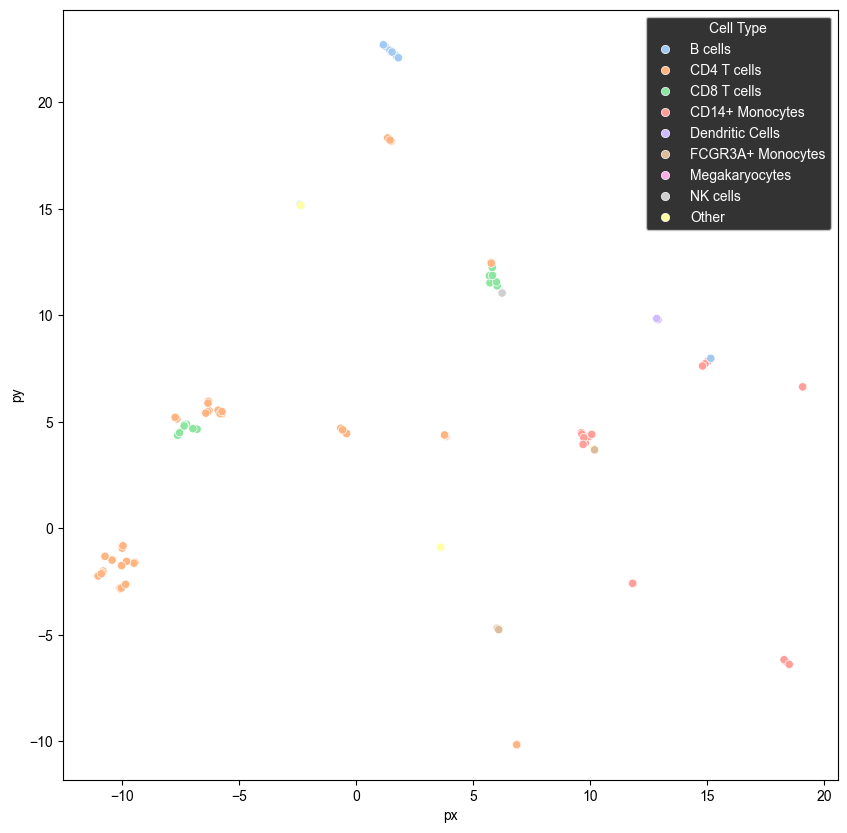

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(embeddings)

labels = ann_data.obs['cell_type'][:100]
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df, x='px', y='py', hue='Cell Type', sizes=(50,200), ax=ax, palette="pastel")
